# Time Independent genesis simulation results and optimization
## 2019.12.13
### Ivan Gadjev
---

## Context

In a time independent genesis simulation, the beam energy, `GAMMA0`, and the resonant wavelength, `XLAMDS`, must be finely tuned in order to maximize gain. This is due to the inherent assumption of the time independent simulations that there is a single frequency of radiation produced in the FEL. 

---

## Simulation workflow

1. Optimize genesis.
If major changes are needed to an input file (especially for .ele and .lte files) it is recommended to edit the files separetely in a text editor. 

`genesis/genesis+scan > post-process genesis`

2. Use the created input file as a starting point for the beam conditioning cases


---

hello this is an equation on its own: $$\alpha = \beta + \exp(-i)$$

In [1]:
# reloads modules so that import does not have be run every time a module is changed
%load_ext autoreload
%autoreload 2

In [2]:
# needs sdds python module. see the elegant documentation.
import sdds

import datetime
import os
import sys
# !!! please change this path to match your configuration !!!
sys.path.append('D:/Dropbox/py_projects/elegenapi/src/features')
import elegenapi as ega

import numpy as np
import scipy.constants as pc
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as mcm

In [3]:
def print_stats(genpar, zrecnum=0):
    """ Helper function that prints some relevant stats for the 6D particle distribution contained in genpar.data.
    
    """
    
    zrec = genpar.data.zrec == zrecnum
    
    xmean = 1e6*genpar.data[zrec].xposition.values.mean()
    xstd =  1e6*genpar.data[zrec].xposition.values.std()
    ymean = 1e6*genpar.data[zrec].yposition.values.mean()
    ystd =  1e6*genpar.data[zrec].yposition.values.std()

    print('x mean = {:06.3f} um\nx std = {:06.3f} um'.format(*[xmean, xstd]))
    print('y mean = {:06.3f} um\ny std = {:06.3f} um'.format(*[ymean, ystd]))

    pxmean = 1e3*genpar.data[zrec].xmomentum.values.mean()
    pxstd =  1e3*genpar.data[zrec].xmomentum.values.std()
    pymean = 1e3*genpar.data[zrec].ymomentum.values.mean()
    pystd =  1e3*genpar.data[zrec].ymomentum.values.std()

    print('px mean = {:06.3f} mrad\npx std = {:06.3f} mrad'.format(*[pxmean, pxstd]))
    print('py mean = {:06.3f} mrad\npy std = {:06.3f} mrad'.format(*[pymean, pystd]))
    
    return [xmean, xstd, ymean, ystd, pxmean, pxstd, pymean, pystd]

### Scan

In [4]:
genpath = r'D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/'

# if you want to make a new subfolder for today's simulations
datenow = str(datetime.date.today())
genpath = genpath + datenow + '/'

print(genpath)

if os.path.exists(genpath):
    os.chdir(genpath)
else:
    os.mkdir(genpath)
    os.chdir(genpath)

D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/2020-03-23/


In [93]:
# init genesis control class
gc = ega.GenControl(0)

# check if there is an input file in directory. if there is not, make it.
genin = 'lpaxfel.in'
if os.path.isfile(genin):
    print('using genesis input file: ' + genpath+genin)
else:
    print('nope')
    gc.make_infile(genin)
    
# run genesis
# specify the output file (note there is a limit on the number of characters in the name, because genesis is old)
# 2020.03.23 - make current peak to 5kA - Alex+Jamie request
genout = 'lpaxfel_DF0_00'
chparams = {'nwig':350,
            'GAMMA0':452,
            'XLAMDS':80.0e-9,
            'RXBEAM':49.0e-6,
            'RYBEAM':46.0e-6,
            'CURPEAK':5e3,
            'NSCZ':1,
            'zstop':-1,
            'ippart':0,
            'scan':'GAMMA0',
            'nscan':11,
            'svar':0.0025,
            'distfile':'delete',
            'outputfile':"'"+genout+"'"}
gc.param_set(genin, chparams)

try:
    gc.run_genesis(genin)
    print('genesis run with input file: ' + genin)
except:
    print('FAILED to run genesis.')

using genesis input file: D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/2020-03-23/lpaxfel.in
Run `genesis`.
genesis run with input file: lpaxfel.in


In [94]:
go = ega.GenOut()
genout = 'lpaxfel_DF0_00'
go.load(genout)
print('The available data columns are:\n' + str(go.colnames))

The available data columns are:
['z', 'aw', 'qfld', 'power', 'increment', 'powermid', 'realfieldmid', 'imagfieldmid', 'phasemid', 'w', 'wp', 'energy', 'bunching_1', 'realbunching_1', 'imagbunching_1', 'bunching_2', 'realbunching_2', 'imagbunching_2', 'bunching_3', 'realbunching_3', 'imagbunching_3', 'bunching_4', 'realbunching_4', 'imagbunching_4', 'bunching_5', 'realbunching_5', 'imagbunching_5', 'bunching_6', 'realbunching_6', 'imagbunching_6', 'bunching_7', 'realbunching_7', 'imagbunching_7', 'xrms', 'yrms', 'xp', 'yp', 'error', 'e-spread', 'farfield', 'slice']


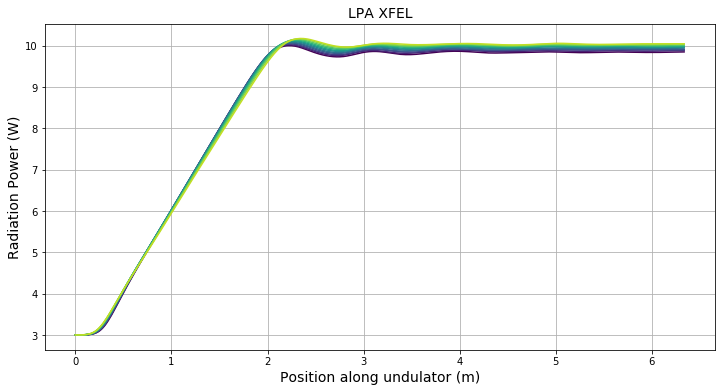

In [95]:
pwrscan = np.zeros([go.nslice,2])
fig, ax = plt.subplots(figsize=(12,6))
for ss in range(go.nslice):
    xvec = go.data[go.data.slice == ss].z
    yvec = np.log10(go.data[go.data.slice == ss].power)
    ax.plot(xvec, yvec, color=mcm.get_cmap('viridis')(ss / go.nslice))
    
    plt.grid()
    
    fs = dict(fontsize=14)
    plt.xlabel('Position along undulator (m)',**fs)
    plt.ylabel('Radiation Power (W)', **fs)
    plt.title('LPA XFEL', fontsize=14)
    
    pwrscan[ss] = [ss, yvec.max()]

In [92]:
for row in pwrscan:
    print(row)
sstemp = 0
np.float(go.paramsin['GAMMA0'][0]) * (1 - np.float(go.paramsin['SVAR'][0]) + 2 * sstemp * np.float(go.paramsin['SVAR'][0]) / np.float(go.paramsin['NSCAN'][0])) 

[ 0.         10.00228651]
[ 1.         10.02458871]
[ 2.         10.04884352]
[ 3.         10.06608091]
[ 4.         10.08466967]
[ 5.         10.10314635]
[ 6.        10.1180385]
[ 7.         10.13671301]
[ 8.         10.15373293]
[ 9.         10.16978501]
[10.         10.18284255]


450.87

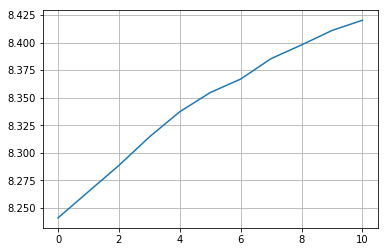

In [10]:
plt.plot(pwrscan[:,0], pwrscan[:,1])
plt.grid()

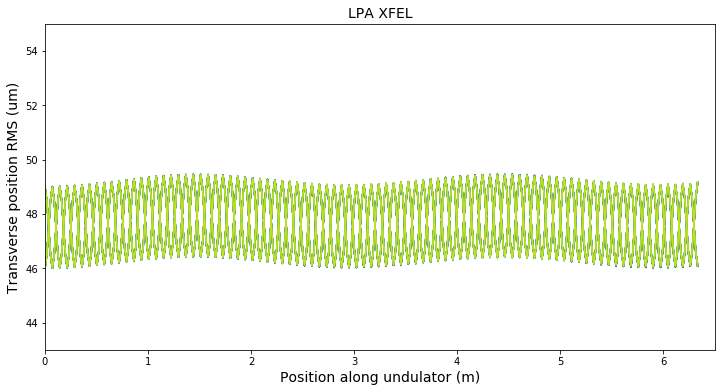

In [96]:
fig, ax = plt.subplots(figsize=(12,6))
for ss in range(go.nslice):
    if go.nslice == 1:
        colorx = 'dodgerblue'
        colory = 'orange'
    else:
        colorx = mcm.get_cmap('viridis')((ss) / go.nslice)
        colory = mcm.get_cmap('viridis')(ss / go.nslice)
    
    
    xvec = go.data[go.data.slice == ss].z
    yvec = 1e6 * (go.data[go.data.slice == ss].xrms)
    ax.plot(xvec, yvec, color=colorx)
    yvec = 1e6 * (go.data[go.data.slice == ss].yrms)
    
    ax.plot(xvec, yvec, color=colory)
    
    plt.axis([0,6.5, 43,55])
#     plt.grid()
    
    fs = dict(fontsize=14)
    plt.xlabel('Position along undulator (m)',**fs)
    plt.ylabel('Transverse position RMS (um)', **fs)
    plt.title('LPA XFEL', fontsize=14)
    

